In [20]:
import numpy as np
import cv2
import pickle
import glob
from tracker import tracker

# read in the saved objpoint and imgpoints 
dist_pickle = pickle.load(open("./camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# useful function for producing the binary pixel of interest images to feed into the LaneTracker Algorithm
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    #calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255* abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)

    #Apply threshold
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output
     
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    #calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)

    #apply threshold
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    #calculate gradient direction 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        binary_output = np.zeros_like(absgraddir)
        #apply threshold
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


def color_threshold(image, sthresh=(0, 255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), max(0, int(center-width)):min(int(center+width), img_ref.shape[1]) ] = 1
    return output


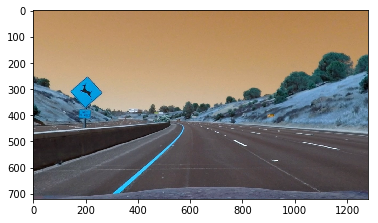

In [32]:
import matplotlib.pyplot as plt

#make a list of test images 
images = glob.glob('./test_images/test*.jpg')

for idx, fname in enumerate(images):

    #read in image
    img = cv2.imread(fname)

    #undistort image 
    img = cv2.undistort(img, mtx, dist, None, mtx)
    

plt.imshow(img)
plt.show()

In [36]:
def undistort_image(img):
    
    result_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return result_img

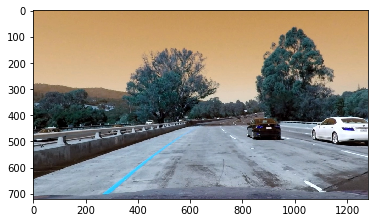

In [42]:
img = cv2.imread('./test_images/test1.jpg')


undistorted_image = undistort_image(img)

write_name = './test_images/undistorted_image_1.jpg'
cv2.imwrite(write_name, undistorted_image)

import matplotlib.pyplot as plt
plt.imshow(undistorted_image)
plt.show()

In [51]:
def binary_image(img):
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    #process image and generate binary ppixels of 
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh=(12,255)) #12
    grady = abs_sobel_thresh(img, orient='y', thresh=(25, 255)) #15
    c_binary = color_threshold(img, sthresh=(100, 255), vthresh=(50, 255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255 # TODO
    
    return preprocessImage

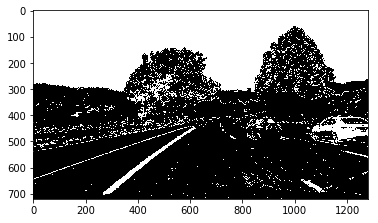

In [54]:
img = cv2.imread('./test_images/test1.jpg')


binary_img = binary_image(img)

write_name = './test_images/binary_image_1.jpg'
cv2.imwrite(write_name, binary_img)

import matplotlib.pyplot as plt
plt.imshow(binary_img, cmap = 'gray')
plt.show()